My notes from working through section 3, experiments and significance testing, of [Practical statistics for data science](https://learning.oreilly.com/library/view/practical-statistics-for/9781492072935/), to revise consepts and get comfortable implementing them in Python.


### The basic experimental process:
- Formulate a hypothesis
- Design experiment
- Collect data
- Draw inferences and conclusions

### Hypothesis testing

- The book makes a nice point about why we need hypothesis testing in the first place: to guard against our tendency to underestimate chance, and, as a result, to interprete observed differences as being driven by something "real" (e.g. our treatment).
- A nice example is our intuition of what a random series of coin flips looks like: most people will switch between heads and tail too frequently, believing that five heads in a row are very unlikely in a series of 50 flips (which it is not).

### Resampling
- Means to repeatedly sample values from observed data to assess variability in a statistic.
- There are two main approaches: the bootstrap, usually used to assessed to reliability of an estimate (see distributions notebook), and permutation tests, used to test hypotheses.

### Permutation tests

- Is a way to perform hypothesis testing while being agnostic about the outcome distribution. In a traditional hypothesis test, we assume that the outcome variable (e.g. the difference between treatment and control outcome) has a certain distribution (usually t or standard normal) and then see where in that distribution the observed outcome falls: if it's far out on either tail of the distribution, beyond some critical value (usually the 2.5th percentile on either end) we conclude that the result is unlikely to be produced by chance and reject the null hypothesis.
- A permutation test works the same except that we don't compare our outcome to a theoretical distribution, but to a distribution we create. We create the distribution by pooling all outcome data, resampling (without replacement) to construct groups of the size of each treatment group, and then comparing the outcomes. This outcome is one observation. We then repeat this procedure R times to build a distribution of outcomes, and finally compare our original outcome to the distribution to see where it falls and how likely it is to be a product of chance.
- Permutation tests come in three variants: random permutation tests, exhaustive permuation tests, and bootstrap permutation tests. The first is as described above, in the second we construct our permutatin samples such that they cover all possible cases we can construct, and in a bootstrap test we sample with replacement. The exhaustive test is sometimes clled "exact test" because it guarantees that we will not find a significant result more often than the alpha level of the test. Bootstrap resampling models not only the randomness in the treatment allocation to subjects (as random variation does) but also the randomness in the sampling of subjects from a population. 

In [179]:
# Example random permutation test for web stickiness

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format ='retina'

# Create sample dataset
np.random.seed(2312)
sessions_a = np.random.normal(3.5, 1, 25)
sessions_b = np.random.normal(4.5, 1, 15)
session_times = np.concatenate([sessions_a, sessions_b ])
groups = ['a'] * 25 + ['b'] * 15
df = pd.DataFrame({'group': groups, 'session_time': session_times})
df.sample(3)

,group,session_time
4,a,4.514161
31,b,4.621471
2,a,4.124164


Mean difference in session times is 0.51 seconds.


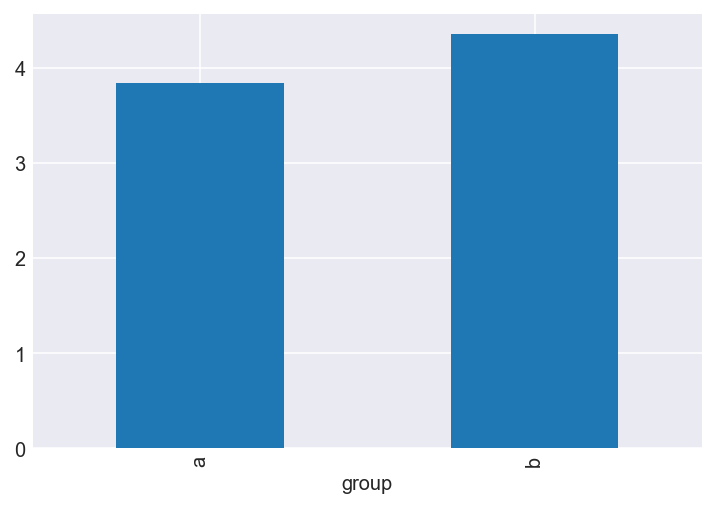

In [189]:
# Calculate and plot means

mean_a = df[df['group'] == 'a'].session_time.mean()
mean_b = df[df['group'] == 'b'].session_time.mean()
mean_diff = mean_b - mean_a
df.groupby('group').mean().plot(kind='bar', legend=None)
print(f'Mean difference in session times is {mean_diff:.2} seconds.')

In [190]:
# Create permutations

def random_perm(x, n_a, n_b):
    """ Return difference in x for random groups of size n_a 
    and n_b (groups are sampled without replacement). """
    n = n_a + n_b
    idx_a = set(random.sample(range(n), n_a))
    idx_b = set(range(n)) - idx_a
    return x.loc[idx_a].mean() - x.loc[idx_b].mean()

def bootstrap_perm(x, n_a, n_b):
    """ Return difference in x for random groups of size n_a 
    and n_b (groups are sampled with replacement). """
    n = n_a + n_b
    idx_a = random.choices(range(n), k=n_a)
    idx_b = random.choices(range(n), k=n_b)
    return x.loc[idx_a].mean() - x.loc[idx_b].mean()

random_diffs = [random_perm(x, n_a, n_b) for _ in range(1000)]
bootstrap_diffs = [bootstrap_perm(x, n_a, n_b) for _ in range(1000)]

Random: P-value of observed difference is 0.079
Bootstrap: P-value of observed difference is 0.078


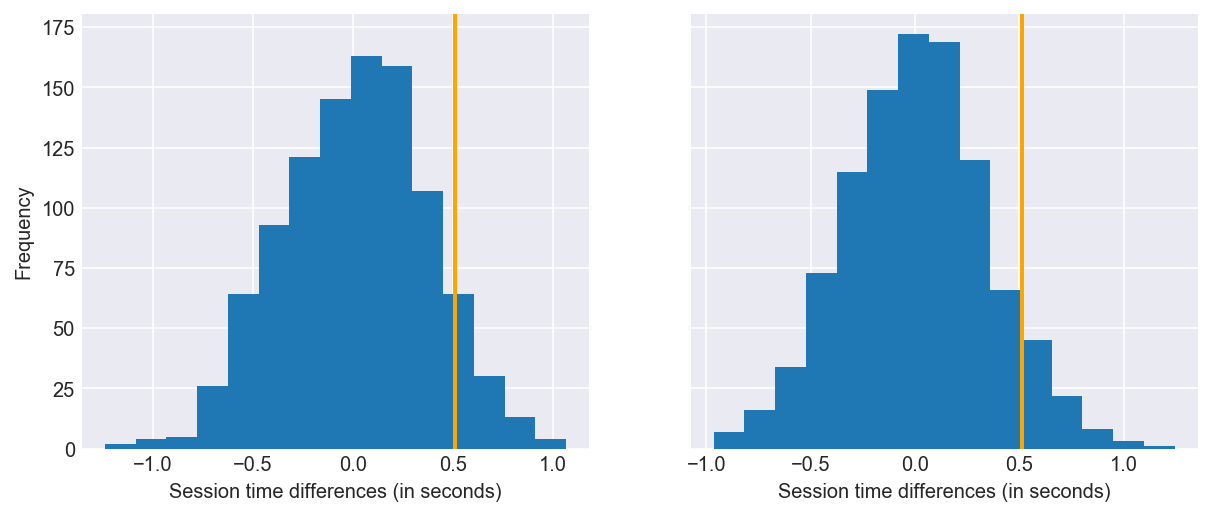

In [191]:
# Plot distribution of permuation differences and group difference and calculate p-value

fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

ax0.hist(random_diffs, bins=15)
ax0.axvline(mean_diff, color='orange', lw=2)
ax0.set_xlabel('Session time differences (in seconds)')
ax0.set_ylabel('Frequency')

ax1.hist(bootstrap_diffs, bins=15)
ax1.axvline(mean_diff, color='orange', lw=2)
ax1.set_xlabel('Session time differences (in seconds)')

p_random = sum(random_diffs > mean_diff) / len(random_diffs)
p_bootstrap = sum(bootstrap_diffs > mean_diff) / len(bootstrap_diffs)
print(f'Random: P-value of observed difference is {p_random}')
print(f'Bootstrap: P-value of observed difference is {p_bootstrap}')

### Comparing resampling and formal testing

We have different conversion rates for two prices A and B as shown below. Test whether the difference in conversion rates is statistically significant at the 5 percent level.

Price A: conversion: 200; non-conversion 23539

Price B: conversion: 182; non-conversion 22406

In [313]:
# Create dataset and calculate difference in conversion rate

a = [200, 23539]; b = [182, 22406]        # [conversions, non-conversions]
groups = ['a'] * sum(a) + ['b'] * sum(b)
outcomes = [1] * a[0] + [0] * a[1] + [1] * b[0] + [0] * b[1]
df = pd.DataFrame({'group': groups, 'conv': outcomes})
df.head()

,group,conv
0,a,1
1,a,1
2,a,1
3,a,1
4,a,1


In [314]:
# Calculate difference in conversion rates

conv_a = df[df['group'] == 'a'].conv.mean()
conv_b = df[df['group'] == 'b'].conv.mean()
conv_diff = conv_a - conv_b
print(f'Difference in conversion rate is {conv_diff * 100:.3} percentage points.')

Difference in conversion rate is 0.0368 percentage points.


In [315]:
# Using resampling to test for significance of difference in conversion rates

random_diffs = [random_perm(df['conv'], sum(a), sum(b)) for _ in range(1000)]

p_random = sum(random_diffs > conv_diff) / len(random_diffs)
print(f'P-value is {p_random}')

P-value is 0.318


In [316]:
# Using a (one-sided) two-proportion z-test

from statsmodels.stats.proportion import proportions_ztest

convs = np.array([a[0], b[0]])
obs = np.array([sum(a), sum(b)])
z, p = proportions_ztest(convs, obs, alternative='larger')
print(f'P-value is {p:.3}')

P-value is 0.331


In [317]:
# Using a (one-sided) Chi-Squared test of independence

import scipy.stats

chi2, p, df, E = scipy.stats.chi2_contingency([[a[0], a[1]], [b[0], b[1]]])
print(f'P-value is {p / 2:.4}')

P-value is 0.3498


In [327]:
# Using a (one-sided) t-test

outcomes_a = outcomes[:sum(a)]
outcomes_b = outcomes[sum(a):]

t, p = scipy.stats.ttest_ind(outcomes_a, outcomes_b, equal_var=False)
print(f'P-value is {p / 2:.4}')

P-value is 0.3309


### Multiple testing

- If we use a significance level of 5 percent, then if we run 20 hypothesis tests the probability that we will at least make one Type I error (find a significant result purely due to chance) is $1 - 0.95^{20} = 0.64$.
- This, in essence, captures the problem of multiple comparisons, which applies similarly to trying out different model specifications and models -- the more you try, the larger the probability that significant results appear due to chance.
- Ways to guard against this: explicit corrections (like Bonferroni) in the case of multiple hypothesis tests, holdout sets in classification tasks, awareness of the problem in unsupervised learning tasks

### ANOVA

- Used to test for significant differences among numeric outcomes of various groups all at once in an omnibus test.
- Alternatively, we could use pairwise comparisons, but for even small numbers of groups this would require many testes (e.g. 6 test for 4 groups), and we'd run into the multiple testing problem.

Observed variance of means is 0.36.


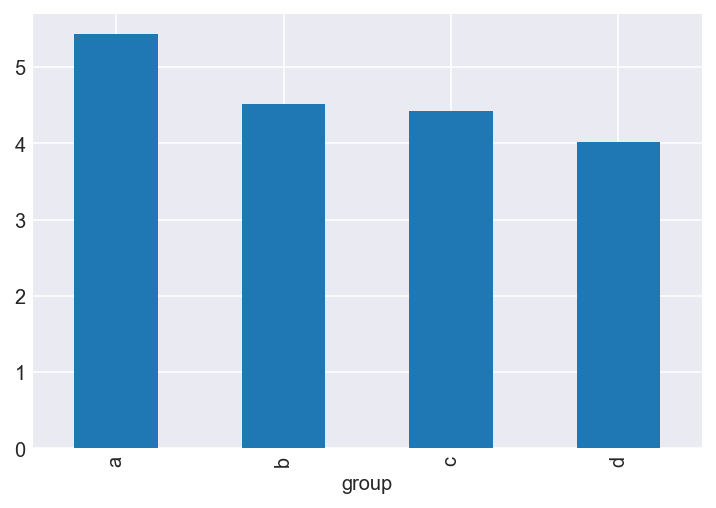

In [368]:
# Create dataset 

np.random.seed(2312)
n = 10
groups = np.sort(['a', 'b', 'c', 'd'] * n)
times_a = np.random.normal(5, 1, n)
times_b = np.random.normal(4.5, 1, n)
times_c = np.random.normal(4.25, 1, n)
times_d = np.random.normal(4, 1, n)
times = np.concatenate([times_a, times_b, times_c, times_d])
df = pd.DataFrame({'group': groups, 'time': times})
df.head()

observed_var = df.groupby('group').mean().var()[0]

df.groupby('group').mean().plot(kind='bar', legend=None);
print(f'Observed variance of means is {observed_var:.2}.')

In [384]:
# Run ANOVA permutation test

def perm_var(df):
    df = df.copy()
    df['time'] = np.random.permutation(df['time'].values)
    return df.groupby('group').mean().var()[0]

p = np.mean([perm_var(df) > observed_var for _ in range(1000)])
print(f'P-value is {p:.2}')

P-value is 0.029
